# Importando o CSV

In [1]:
import pandas as pd
import requests
url = "https://raw.githubusercontent.com/Matheus-B-Ferrari/AnaliseDeSentimentosB3/main/unified_prices_sentiment_novo.csv"
r = requests.get(url)
r.raise_for_status()
open('/content/unified_prices_sentiment_novo.csv', 'wb').write(r.content)
github_df = pd.read_csv('/content/unified_prices_sentiment_novo.csv')
github_df.head()

,date,ticker,open,high,low,close,volume,return_linear,sent_mean,sent_median,sent_std,sent_count
0,2025-05-02,BOVA11.SA,131.619995,132.119995,131.169998,131.850006,5741260.0,NaN,-0.204281,-0.417328,0.587283,82
1,2025-05-05,BOVA11.SA,131.789993,132.100006,130.279999,130.339996,3325658.0,-0.011452,-0.064030,0.050000,0.596815,76
2,2025-05-06,BOVA11.SA,130.869995,131.029999,130.139999,130.380005,4659894.0,0.000307,-0.038192,0.050000,0.642560,80
3,2025-05-07,BOVA11.SA,130.940002,130.990005,129.720001,130.210007,3107370.0,-0.001304,0.016637,0.050000,0.613475,75
4,2025-05-08,BOVA11.SA,132.630005,134.470001,132.509995,133.039993,5772982.0,0.021734,0.181009,0.050000,0.541966,69


# Imports e Configurações

Importando todas as bibliotecas necessárias e definindo configurações globais usadas ao longo do notebook.



In [2]:
import os
import warnings
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

CSV_FILE = "unified_prices_sentiment_novo.csv"
TICKERS = ["PETR4.SA", "EMBR3.SA", "VALE3.SA", "BOVA11.SA"]
START_DATE = "2025-05-01"
END_DATE = "2025-09-01"
WINDOWS = [7, 14]
HORIZONS = [1, 2, 5]
EPOCHS = 100
BATCH_SIZE = 8
LR = 0.001
FEATURES = ["Close"]
SENT_COLS = {"com_sent_median": "sent_median"}  # mapeamento modos
CLOSE_IDX = 0
SAVE_CSVS_ERRORS = True

# Funções Utilitárias

Neste bloco nós agrupamos em funções todas as rotinas reutilizáveis para o pipeline: função de leitura e filtragem por ticker, criação de janelas temporais (sliding windows) que montam X e y para o modelo, funções para normalização/denormalização dos dados, cálculo de métricas (MAE, RMSE, correlação), e helpers para salvar/carregar modelos e resultados.



In [3]:
def download_ticker_from_csv(ticker, start, end, csv_file=CSV_FILE):
    df_all = pd.read_csv(csv_file, engine="python", sep=None)
    df_all.columns = [c.strip() for c in df_all.columns]
    if "date" not in df_all.columns or "ticker" not in df_all.columns:
        raise ValueError("CSV não contém colunas 'date' e/ou 'ticker'.")
    df_all["date"] = pd.to_datetime(df_all["date"])
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    df = df_all[(df_all["ticker"] == ticker) & (df_all["date"] >= start_dt) & (df_all["date"] <= end_dt)].copy()
    if df.empty:
        return pd.DataFrame()
    mapping = {}
    for f in ["open", "high", "low", "close", "volume"]:
        if f in df.columns:
            mapping[f] = f.capitalize()
    df.rename(columns=mapping, inplace=True)
    df["Date"] = pd.to_datetime(df["date"])
    keep_cols = ["Date"] + [c for c in FEATURES if c in df.columns] + [c for c in SENT_COLS.values() if c in df.columns]
    df = df.loc[:, keep_cols]
    df.set_index("Date", inplace=True)
    df = df.sort_index().interpolate().ffill().bfill()
    return df

# def sequences(data, win_length, close_col_idx=CLOSE_IDX):
#     X, y = [], []
#     for i in range(len(data) - win_length):
#         X.append(data[i:i+win_length])
#         y.append(data[i+win_length, close_col_idx])
#     return np.array(X), np.array(y)
#     # Entrada: dias 1–7 -> Saída: dia 8.

def retorno_inverso(preds, scaler, n_features, close_col_idx=CLOSE_IDX):
    full = np.zeros((len(preds), n_features))
    full[:, close_col_idx] = preds.reshape(-1)
    inv = scaler.inverse_transform(full)
    return inv[:, close_col_idx]
    # Desfaz a normalização do MinMaxScaler.
    # Como o modelo foi treinado com dados escalonados (0 a 1), essa função traz os valores de volta a escala original de preços.

def model_build(input_shape):
    model = Sequential([
        # Única LSTM
        LSTM(64, input_shape=input_shape),  # sem return_sequences
        Dropout(0.2),

        # Dense intermediária
        Dense(32, activation='relu'),

        # Saída final
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model

def safe_mape(y_true, y_pred):
    eps = 1e-9
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def sequences_multi_horizon(data, win_length, horizon=1, close_col_idx=0):
    """
    Para horizon=1: usar dias [i:i+win_length] para prever dia [i+win_length]
    Para horizon=2: usar dias [i:i+win_length] para prever dia [i+win_length+1]

    Exemplo com win_length=7, horizon=1:
    - X = dias 0-6 (índices 0,1,2,3,4,5,6)
    - y = dia 7 (índice 7) - primeiro dia APÓS a janela

    Exemplo com win_length=7, horizon=2:
    - X = dias 0-6 (índices 0,1,2,3,4,5,6)
    - y = dia 8 (índice 8) - segundo dia após a janela
    """
    X, y = [], []
    # Precisamos ter dados suficientes: win_length dias para X + horizon dias no futuro
    max_i = len(data) - win_length - horizon

    for i in range(max_i):
        # Janela de entrada: win_length dias consecutivos
        X.append(data[i:i+win_length])
        # Target: o dia que está 'horizon' posições após a janela
        # Para horizon=1: i+win_length (primeiro dia após janela)
        # Para horizon=2: i+win_length+1 (segundo dia após janela)
        y.append(data[i + win_length + horizon - 1, close_col_idx])

    return np.array(X), np.array(y)

# Treino por modos/janelas, retorna resultados agregados + erros por dia

Este bloco executa o treinamento e avaliação dos modelos para cada ativo e combinação de janela e horizonte. Os dados são preparados e normalizados, o modelo LSTM é ajustado, e suas previsões são comparadas aos valores reais para calcular métricas de erro e correlação. Os resultados são agregados por data e salvos em tabelas, permitindo a comparação entre modelos com e sem sentimento.

In [4]:
def process_ticker_horizons(ticker, windows=WINDOWS, horizons=HORIZONS, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR):
    print(f"\nProcessing {ticker}")
    df = download_ticker_from_csv(ticker, START_DATE, END_DATE, CSV_FILE)
    if df.empty:
        print(f"  SKIP {ticker}: no data in range.")
        return pd.DataFrame(), pd.DataFrame()
    if not all([c in df.columns for c in FEATURES]):
        print(f"  Missing price columns in {ticker}: {df.columns.tolist()}")
        return pd.DataFrame(), pd.DataFrame()

    results_rows = []
    errors_rows = []

    modes = ["sem_sent", "com_sent_median"]

    for win in windows:
        print(f"  window = {win}")
        for h in horizons:
            print(f"   horizon = {h}")
            for mode in modes:
                if mode == "sem_sent":
                    data_values = df[FEATURES].values
                else:
                    sent_col = SENT_COLS.get(mode)
                    data_values = np.hstack([df[FEATURES].values, df[[sent_col]].values])

                scaler = MinMaxScaler()
                scaled = scaler.fit_transform(data_values)
                n_features = scaled.shape[1]

                # usar sequences_multi_horizon

                # Normaliza os dados entre 0 e 1 e gera pares (X, y) com base na janela (win) e horizonte (h).
                X, y = sequences_multi_horizon(scaled, win, horizon=h, close_col_idx=CLOSE_IDX)
                if X.size == 0:
                    print(f"    -> few samples for {ticker} w{win} h{h} {mode}; skipping.")
                    continue

                model = model_build((win, n_features))
                model.compile(optimizer=Adam(LR), loss='mae')
                model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

                # gerar previsões ponto-a-ponto (win,h,mode)
                preds = []
                # Para cada i em 0..max_i-1, nossa previsão corresponde a data index: df.index[win + (h-1) + i]
                max_i = len(data_values) - win - (h - 1)
                for i in range(max_i):
                    x_in = scaled[i:i+win].reshape(1, win, n_features)
                    pred_scaled = model.predict(x_in, verbose=0)
                    pred_real = retorno_inverso(pred_scaled, scaler, n_features)
                    preds.append(pred_real[0])
                preds = np.array(preds)

                dates = df.index[win + h - 1:]
                real = df["Close"].iloc[win + h - 1:].values

                # alinhamento das previsões
                print(f"\n[DEBUG] {ticker} | w={win} | h={h} | modo={mode}")
                print("len(preds):", len(preds), "len(real):", len(real))
                print("Últimas datas (real):", df.index[win + (h - 1):][-3:])
                print("Últimas datas (pred):", dates[-3:])
                print("Primeiras datas (real):", df.index[win + (h - 1):][:3])
                print("Primeiras datas (pred):", dates[:3])
                print("Exemplo Real vs Pred:", list(zip(real[:3], preds[:3])))


                if preds.shape[0] != real.shape[0]:
                    print(f"    -> size mismatch preds {preds.shape[0]} vs real {real.shape[0]} for {mode}; skipping metrics.")
                    continue

                errors = real - preds
                abs_errors = np.abs(errors)
                sq_errors = errors**2


                sr_real = pd.Series(real, index=dates)
                sr_pred = pd.Series(preds, index=dates)
                rolling_corr = sr_real.rolling(window=win, min_periods=1).corr(sr_pred)

                # métricas agregadas (agregadas por essa combinação win,h,mode)
                mae = float(np.mean(abs_errors))
                mse = float(np.mean(sq_errors))
                mape = float(safe_mape(real, preds))
                corr_overall = np.nan
                try:
                    corr_overall = float(np.corrcoef(real, preds)[0,1])
                except:
                    corr_overall = np.nan

                results_rows.append({
                    "Ticker": ticker,
                    "Janela": win,
                    "Horizon": h,
                    "Modo": mode,
                    "Erro_Medio": float(np.mean(errors)),
                    "MAE": mae,
                    "MSE": mse,
                    "MAPE(%)": mape,
                    "Correlação": corr_overall
                })

                # registrar cada previsão (por data) com Horizon
                for d, dt in enumerate(dates):
                    errors_rows.append({
                        "Ticker": ticker,
                        "Janela": win,
                        "Horizon": h,
                        "Modo": mode,
                        "Date": dt,
                        "Real": float(real[d]),
                        "Pred": float(preds[d]),
                        "Erro": float(errors[d]),
                        "AbsError": float(abs_errors[d]),
                        "SqError": float(sq_errors[d]),
                        "CorrRolling": float(rolling_corr.iloc[d]) if not np.isnan(rolling_corr.iloc[d]) else np.nan
                    })

                # salva csv com horizon
                if SAVE_CSVS_ERRORS:
                    out_name = f"errors_{ticker}_win{win}_h{h}_{mode}.csv".replace("/", "_")
                    df_tmp = pd.DataFrame({
                        "Date": dates,
                        "Real": real,
                        "Pred": preds,
                        "Erro": errors,
                        "AbsError": abs_errors,
                        "SqError": sq_errors,
                        "CorrRolling": rolling_corr.values
                    })
                    df_tmp.set_index("Date", inplace=True)
                    df_tmp.to_csv(out_name)
                    print(f"    -> saved {out_name}")

    results_df = pd.DataFrame(results_rows)
    errors_df = pd.DataFrame(errors_rows)
    return results_df, errors_df

# Função para reconstruir e plotar Preço Real vs Previsões

A função desse bloco recebe as previsões e suas janelas originais e reconstrói séries temporais comparáveis com os preços reais: realiza a denormalização quando necessário, alinha os timestamps correspondentes a cada previsão e concatena os valores previstos com a série real. Em seguida gera gráficos de série temporal que sobrepõem preço real e previsões.

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_forecasts_csvs_horizon(
    ticker,
    windows=WINDOWS,
    horizons=HORIZONS,
    csv_pattern="errors_{ticker}_win{win}_h{h}_{mode}.csv",
    figsize=(14,6),
    max_lines_legend=12
):
    sns.set(style="whitegrid")
    modes = {"sem_sent": "Sem Sentimento", "com_sent_median": "Com Sentimento"}

    # aceita ticker único ou lista
    tickers = ticker if isinstance(ticker, (list, tuple)) else [ticker]

    for tk in tickers:
        # junta todos os CSVs relevantes do ticker
        rows = []
        combos_present = set()
        for win in windows:
            for h in horizons:
                for mode in modes.keys():
                    fname = csv_pattern.format(ticker=tk, win=win, h=h, mode=mode).replace("/", "_")
                    if not os.path.exists(fname):

                        continue
                    try:
                        dfp = pd.read_csv(fname, parse_dates=["Date"])
                    except Exception as e:
                        print(f"Erro lendo {fname}: {e}")
                        continue
                    dfp = dfp[['Date', 'Real', 'Pred']].copy()
                    dfp['Mode'] = modes[mode]
                    dfp['Window'] = int(win)
                    dfp['Horizon'] = int(h)
                    dfp['Combo'] = f"w{win}_h{h}"
                    combos_present.add(f"w{win}_h{h}")
                    rows.append(dfp)

        if not rows:
            print(f"[plot_forecasts] Nenhum arquivo encontrado para {tk}. Pulando.")
            continue

        df_all = pd.concat(rows, ignore_index=True)


        combos_sorted = sorted(list(combos_present), key=lambda s: (int(s.split('_')[0].lstrip('w')), int(s.split('_')[1].lstrip('h'))))


        modes_order = [modes[k] for k in ["sem_sent", "com_sent_median"]]
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
        if len(axes.shape)==0:
            axes = [axes]

        for ax_idx, mode_name in enumerate(modes_order):
            ax = axes[ax_idx]
            sub = df_all[df_all['Mode'] == mode_name]

            # plot Real (uma única linha agregada por Date)
            real = sub.groupby('Date')['Real'].mean().reset_index()
            ax.plot(real['Date'], real['Real'], color='black', linewidth=2.2, label='Real')

            # plot Pred para cada combo
            palette = sns.color_palette("tab10", n_colors=max(3, len(combos_sorted)))
            for i, combo in enumerate(combos_sorted):
                subc = sub[sub['Combo'] == combo]
                if subc.empty:
                    continue
                # se existir duplicidade por Date, média
                pred = subc.groupby('Date')['Pred'].mean().reset_index()
                # gera label curto no formato "W7 / H1"
                w_val = combo.split('_')[0].lstrip('w')
                h_val = combo.split('_')[1].lstrip('h')
                label_curto = f"W{w_val} / H{h_val}"

                ax.plot(
                    pred['Date'],
                    pred['Pred'],
                    linestyle='-',
                    linewidth=1.2,
                    color=palette[i % len(palette)],
                    label=label_curto
                )
            ax.set_title(f"{tk} — {mode_name}")
            ax.set_xlabel("Data")
            if ax_idx == 0:
                ax.set_ylabel("Preço (R$)")
            else:
                ax.set_ylabel("")
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis="x", rotation=40)


        handles, labels = axes[0].get_legend_handles_labels()
        seen = set()
        legend_items = []
        for h, l in zip(handles, labels):
            if l not in seen:
                legend_items.append((h,l))
                seen.add(l)


        fig.legend(
            [h for h, l in legend_items],
            [l for h, l in legend_items],
            loc='upper center',
            bbox_to_anchor=(0.5, 1.12),
            ncol=len(legend_items),
            frameon=False,
            fontsize=9
        )


        fig.set_size_inches(14, 7)
        plt.tight_layout(rect=[0, 0, 1, 1])
        plt.show()
        plt.close(fig)

# Boxplots por Ticker (MAE e Correlação rolling)

Aqui criamos visualizações estatísticas por ativo para sintetizar o desempenho do modelo: são contruídos boxplots da distribuição de MAE por ticker para mostrar variabilidade entre ativos. Esses gráficos ajudam a identificar outliers e ativos com alta variância de erro.

In [6]:
def plot_boxplots_per_ticker_with_horizons(errors_df, ticker, windows=None, horizons=None, save_figs=False, out_dir="./boxplots/"):
    sns.set(style="whitegrid")

    # coluna de erro
    col_error = "AbsError" if "AbsError" in errors_df.columns else "MAE"
    col_modo = "Modo"
    col_window = "Janela"
    col_horizon = "Horizon"
    col_ticker = "Ticker"

    df_t = errors_df[errors_df[col_ticker] == ticker].copy()
    df_t = df_t[df_t[col_modo].isin(["sem_sent", "com_sent_median"])]

    if df_t.empty:
        print(f"[boxplots] sem dados para {ticker}")
        return

    os.makedirs(out_dir, exist_ok=True)

    if windows is None:
        windows = sorted(df_t[col_window].unique())
    if horizons is None:
        horizons = sorted(df_t[col_horizon].unique())

    # cria uma label combinada de janela + horizon para o eixo x
    df_t["Grupo"] = df_t[col_window].astype(str) + "d_w" + df_t[col_horizon].astype(str)

    # ordenar os grupos pelo número de janela e horizon
    df_t["Grupo"] = pd.Categorical(df_t["Grupo"],
                                   categories=sorted(df_t["Grupo"].unique(),
                                   key=lambda x: (int(x.split("d_w")[0]), int(x.split("d_w")[1]))),
                                   ordered=True)

    plt.figure(figsize=(12,6))
    ax = sns.boxplot(data=df_t, x="Grupo", y=col_error, hue=col_modo,
                     palette={"sem_sent": "#4C72B0", "com_sent_median": "#C44E52"},
                     showfliers=True)
    sns.stripplot(data=df_t, x="Grupo", y=col_error, hue=col_modo,
                  dodge=True, color='black', size=3, jitter=True, alpha=0.4, linewidth=0)

    # corrige legenda duplicada
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles[:2], labels[:2], title="Modo")

    # rótulos mais legíveis no eixo X
    ax.set_xticklabels([g.replace("d_w", "d / h") for g in df_t["Grupo"].cat.categories])

    plt.title(f"{ticker} — Erro Absoluto por Janela e Horizon")
    plt.xlabel("Janela / Horizon (dias)")
    plt.ylabel("Erro Absoluto (|Real - Pred|)")
    plt.tight_layout()

    if save_figs:
        fname = os.path.join(out_dir, f"{ticker}_MAE_boxplot_grouped.png")
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        print(f"[boxplots] salvo: {fname}")

    plt.show()
    plt.close()

# Execução: processa tickers e plota

In [7]:
# Execução principal com horizons
all_results = []
all_errors = []

for t in TICKERS:
    res_df, err_df = process_ticker_horizons(t, windows=WINDOWS, horizons=HORIZONS, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR)
    if not res_df.empty:
        all_results.append(res_df)
    if not err_df.empty:
        all_errors.append(err_df)


Processing PETR4.SA
  window = 7
   horizon = 1

[DEBUG] PETR4.SA | w=7 | h=1 | modo=sem_sent
len(preds): 78 len(real): 78
Últimas datas (real): DatetimeIndex(['2025-08-27', '2025-08-28', '2025-08-29'], dtype='datetime64[ns]', name='Date', freq=None)
Últimas datas (pred): DatetimeIndex(['2025-08-27', '2025-08-28', '2025-08-29'], dtype='datetime64[ns]', name='Date', freq=None)
Primeiras datas (real): DatetimeIndex(['2025-05-13', '2025-05-14', '2025-05-15'], dtype='datetime64[ns]', name='Date', freq=None)
Primeiras datas (pred): DatetimeIndex(['2025-05-13', '2025-05-14', '2025-05-15'], dtype='datetime64[ns]', name='Date', freq=None)
Exemplo Real vs Pred: [(np.float64(30.49822807312012), np.float64(30.120297127994494)), (np.float64(30.289400100708008), np.float64(30.609779320180678)), (np.float64(30.251434326171875), np.float64(30.476012116580026))]
    -> saved errors_PETR4.SA_win7_h1_sem_sent.csv

[DEBUG] PETR4.SA | w=7 | h=1 | modo=com_sent_median
len(preds): 78 len(real): 78
Últimas 

# Resultados

Resumo final agregado:


,Ticker,Janela,Horizon,Modo,Erro_Medio,MAE,MSE,MAPE(%),Correlação
0,PETR4.SA,7,1,sem_sent,0.079003,0.301124,0.171185,0.984300,0.894601
1,PETR4.SA,7,1,com_sent_median,0.017745,0.276090,0.144374,0.903266,0.908697
2,PETR4.SA,7,2,sem_sent,-0.053667,0.432690,0.330678,1.417986,0.784603
3,PETR4.SA,7,2,com_sent_median,-0.001876,0.377175,0.253859,1.235481,0.834364
4,PETR4.SA,7,5,sem_sent,0.202169,0.785866,0.830974,2.557715,0.357092
5,PETR4.SA,7,5,com_sent_median,0.048078,0.644317,0.690351,2.103362,0.465707
6,PETR4.SA,14,1,sem_sent,0.053425,0.299088,0.168789,0.978505,0.902963
7,PETR4.SA,14,1,com_sent_median,-0.025641,0.250175,0.127103,0.820925,0.927397
8,PETR4.SA,14,2,sem_sent,0.157306,0.443331,0.330511,1.443459,0.812178
9,PETR4.SA,14,2,com_sent_median,-0.007650,0.267943,0.147899,0.878191,0.914479


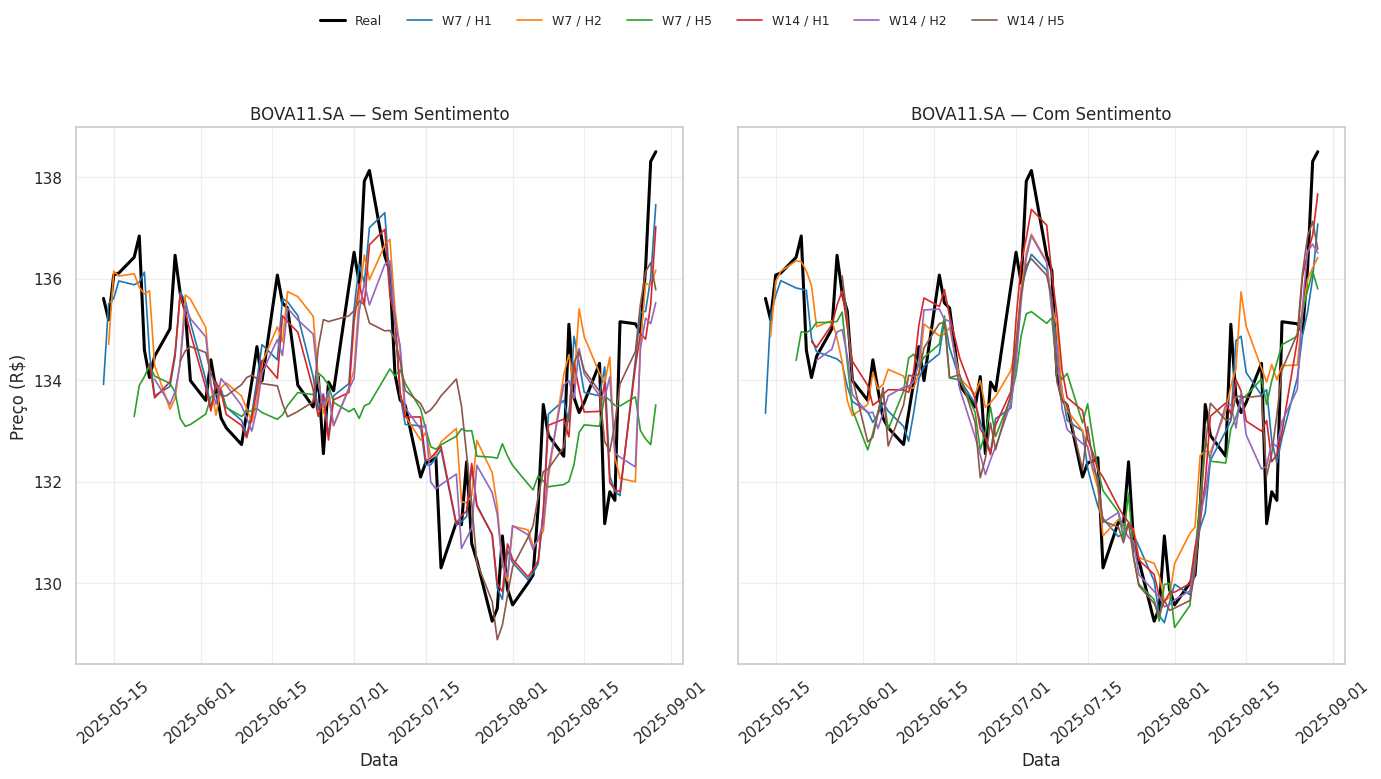

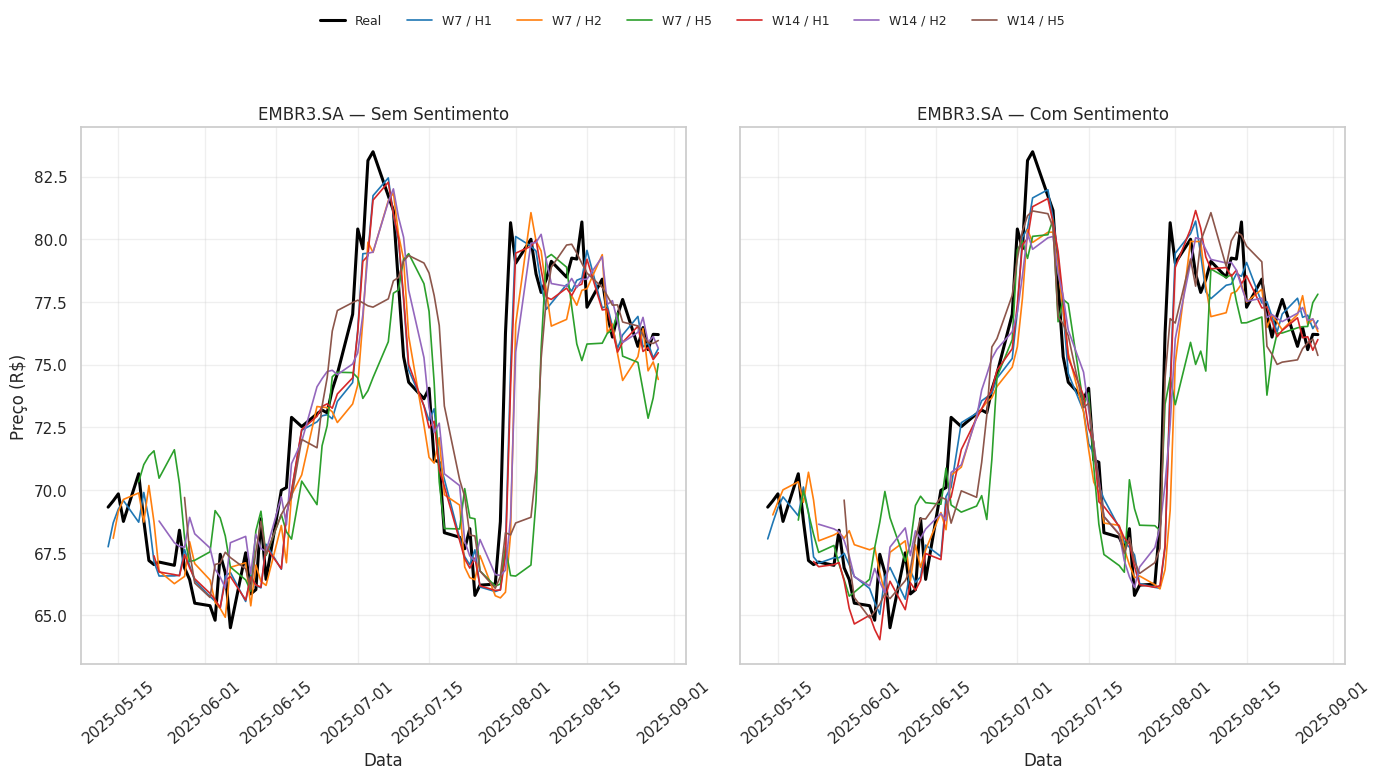

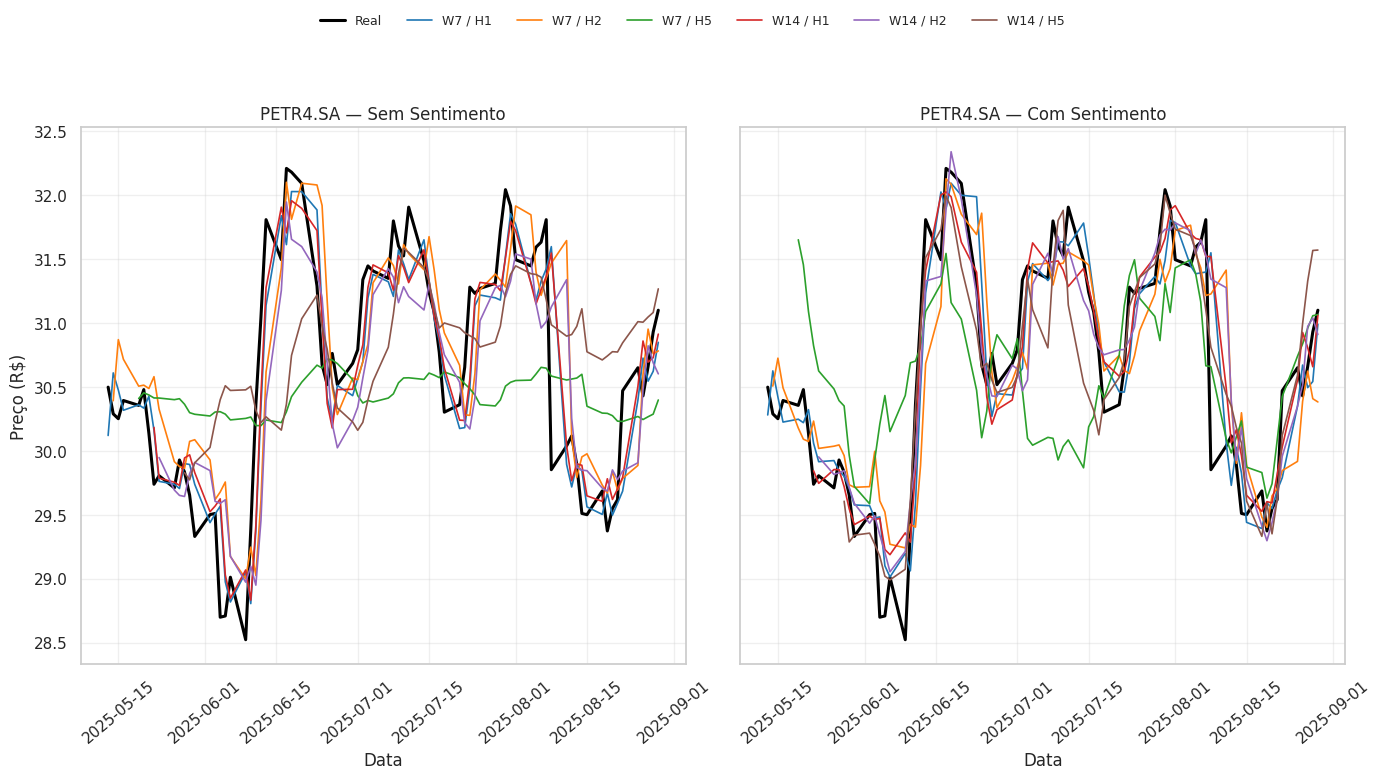

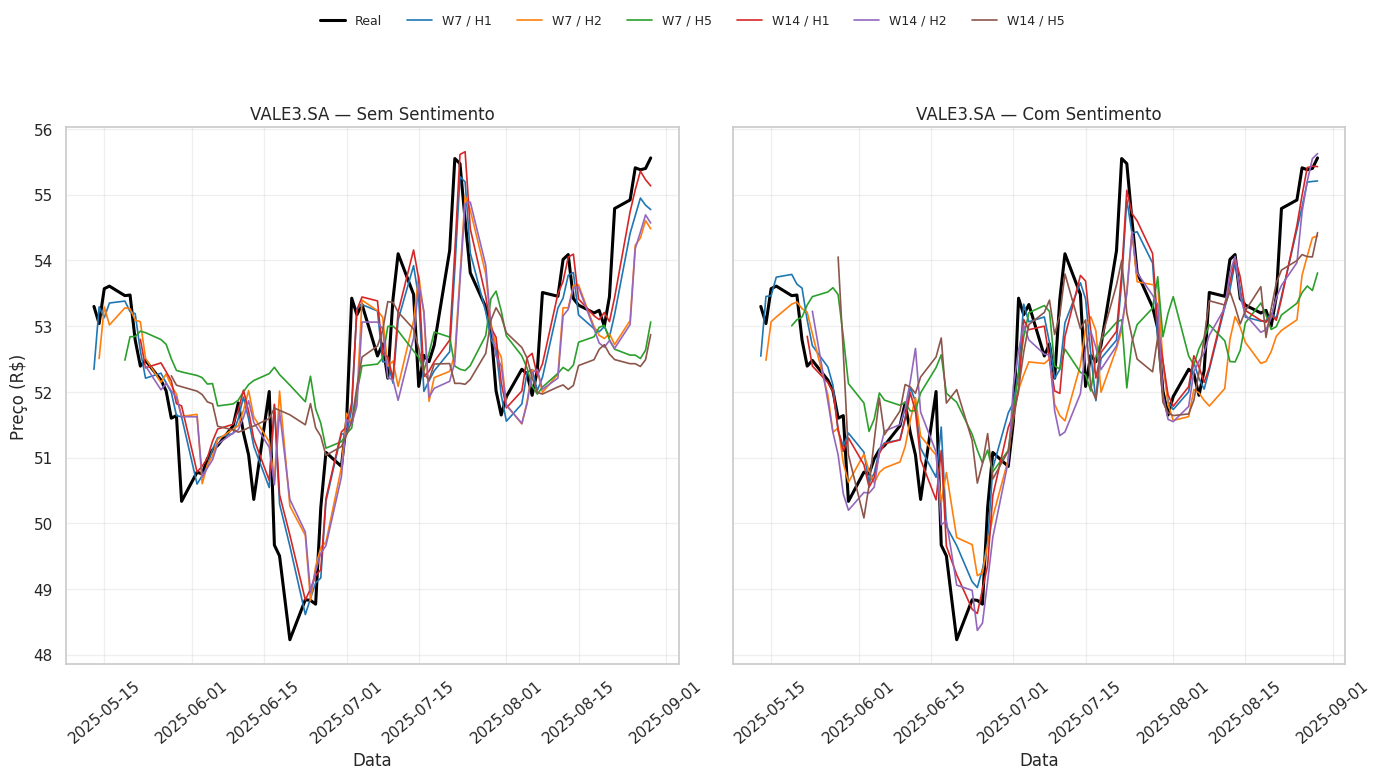

/tmp/ipython-input-3012228863.py:38: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_t, x="Grupo", y=col_error, hue=col_modo,


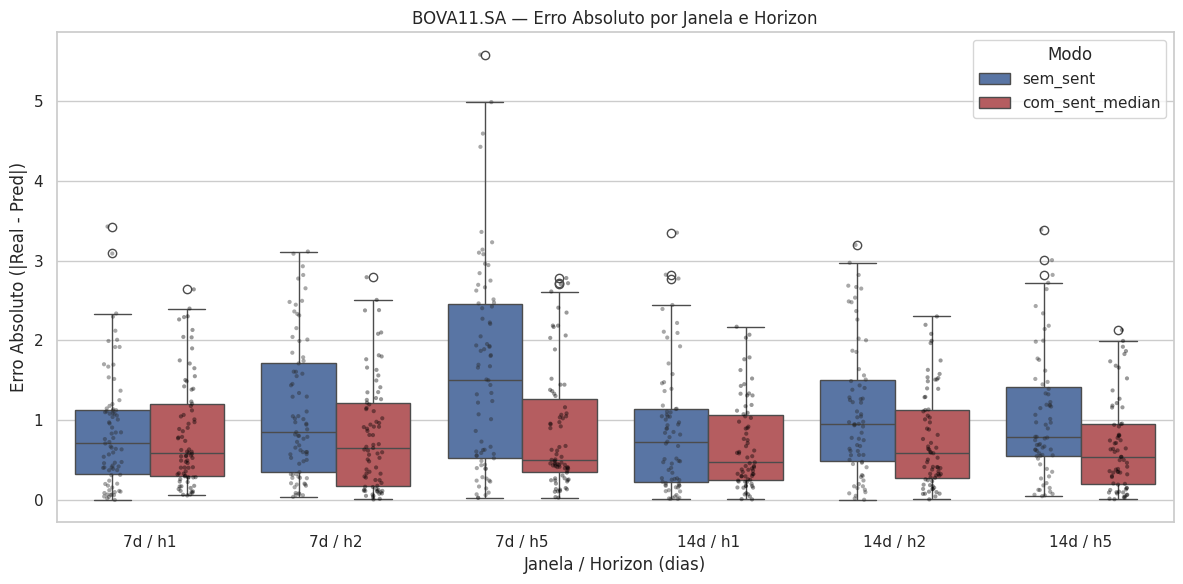

/tmp/ipython-input-3012228863.py:38: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_t, x="Grupo", y=col_error, hue=col_modo,


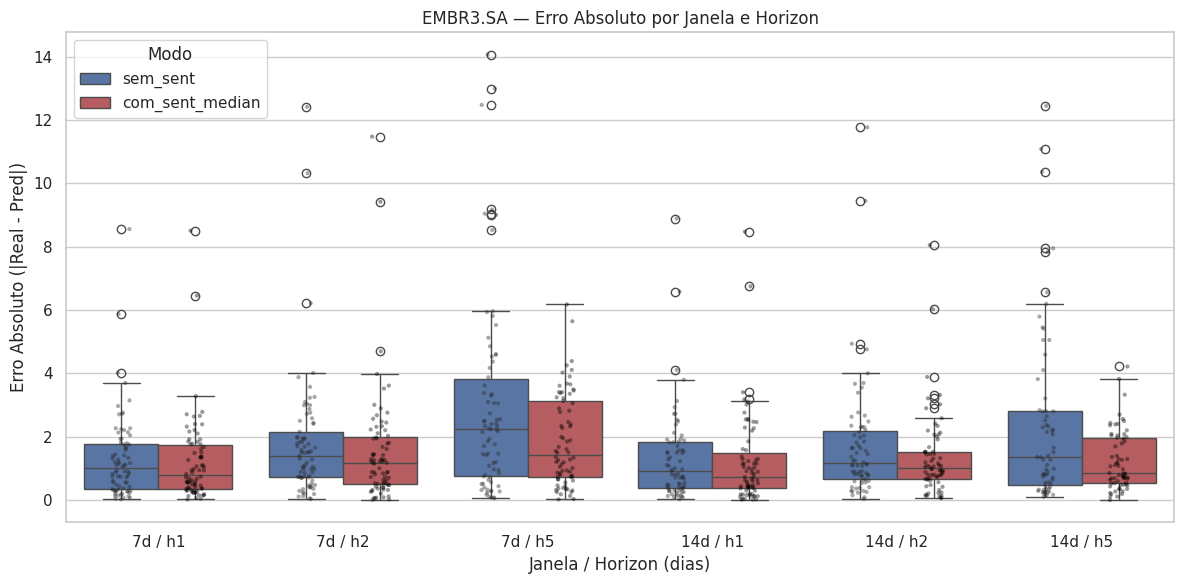

/tmp/ipython-input-3012228863.py:38: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_t, x="Grupo", y=col_error, hue=col_modo,


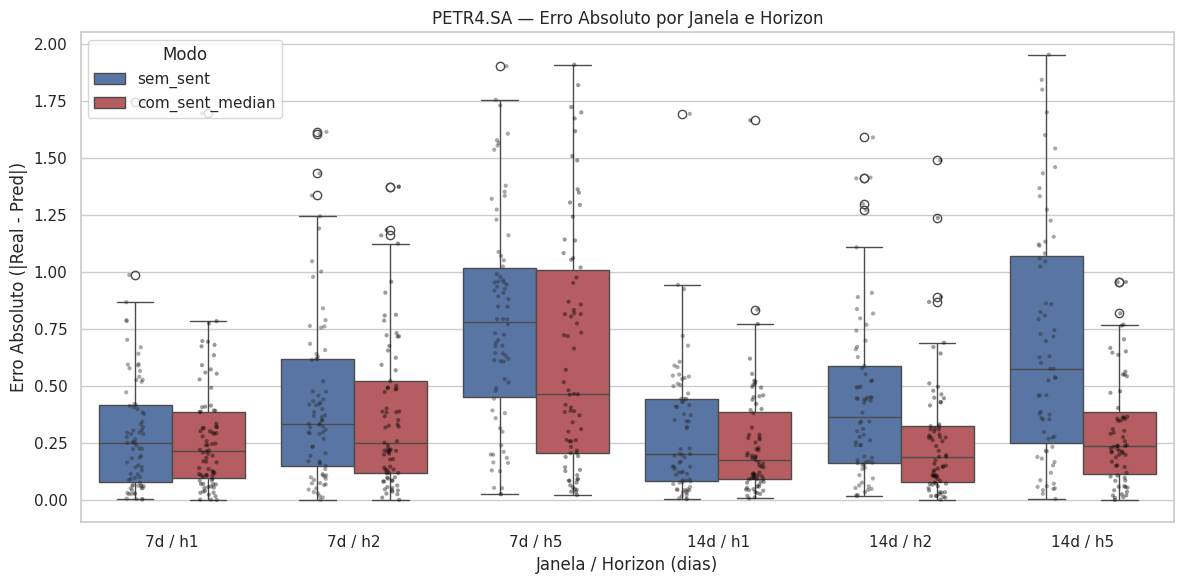

/tmp/ipython-input-3012228863.py:38: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_t, x="Grupo", y=col_error, hue=col_modo,


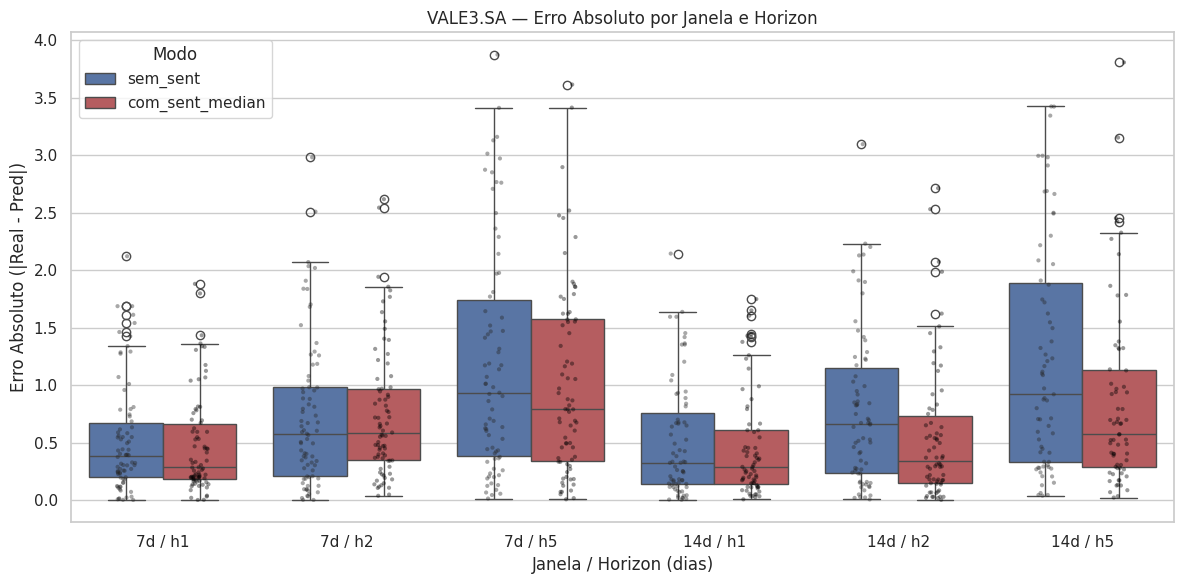

In [8]:
resultados_df = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()
errors_df = pd.concat(all_errors, ignore_index=True) if all_errors else pd.DataFrame()

print("Resumo final agregado:")
display(resultados_df)

# Forecast plots
for t in sorted(errors_df["Ticker"].unique()):
    plot_forecasts_csvs_horizon(t, windows=WINDOWS, horizons=HORIZONS)

for t in sorted(errors_df["Ticker"].unique()):
    plot_boxplots_per_ticker_with_horizons(errors_df, t)

# Testes de Hipótese



## Erros

A média de erros é menor com sentimento que sem sentimento? Em que casos?

Faltou o MAPE alguma medida de erro que permita somar o erro de ativos com valores em escalas diferentes.

Talvez tenham que corrigir para tirar valores ausentes... isso poderia melhorar os resultados, mas não fiz isso aqui.

In [9]:
errors_df

,Ticker,Janela,Horizon,Modo,Date,Real,Pred,Erro,AbsError,SqError,CorrRolling
0,PETR4.SA,7,1,sem_sent,2025-05-13,30.498228,30.120297,0.377931,0.377931,0.142832,NaN
1,PETR4.SA,7,1,sem_sent,2025-05-14,30.289400,30.609779,-0.320379,0.320379,0.102643,-1.000000
2,PETR4.SA,7,1,sem_sent,2025-05-15,30.251434,30.476012,-0.224578,0.224578,0.050435,-0.916765
3,PETR4.SA,7,1,sem_sent,2025-05-16,30.393814,30.317494,0.076320,0.076320,0.005825,-0.920247
4,PETR4.SA,7,1,sem_sent,2025-05-19,30.355846,30.360234,-0.004388,0.004388,0.000019,-0.918457
...,...,...,...,...,...,...,...,...,...,...,...
3491,BOVA11.SA,14,5,com_sent_median,2025-08-25,135.110001,134.917264,0.192736,0.192736,0.037147,0.763553
3492,BOVA11.SA,14,5,com_sent_median,2025-08-26,134.940002,136.098890,-1.158887,1.158887,1.343020,0.708405
3493,BOVA11.SA,14,5,com_sent_median,2025-08-27,136.199997,136.821183,-0.621186,0.621186,0.385872,0.799716
3494,BOVA11.SA,14,5,com_sent_median,2025-08-28,138.309998,137.126938,1.183060,1.183060,1.399631,0.866211


In [10]:
resultados_df[ (resultados_df["Janela"] == 7) & (resultados_df["Horizon"] == 1)  & (resultados_df["Modo"] == "sem_sent") ]


,Ticker,Janela,Horizon,Modo,Erro_Medio,MAE,MSE,MAPE(%),Correlação
0,PETR4.SA,7,1,sem_sent,0.079003,0.301124,0.171185,0.984300,0.894601
12,EMBR3.SA,7,1,sem_sent,0.549152,1.308053,3.492219,1.777643,0.942517
24,VALE3.SA,7,1,sem_sent,0.126410,0.522003,0.501239,0.994321,0.907915
36,BOVA11.SA,7,1,sem_sent,0.095472,0.860085,1.254079,0.641852,0.859825


In [11]:
from scipy import stats

def ttest_a_greater_than_b(a, b, alpha=0.05):
    """
    Performs a one-tailed t-test to determine if the mean of sample 'a' is
    significantly greater than the mean of sample 'b'.

    H0: mean(a) <= mean(b)
    Ha: mean(a) > mean(b)

    Args:
        a (list or np.array): The first independent sample.
        b (list or np.array): The second independent sample.
        alpha (float): The significance level.

    Returns:
        tuple: (
            bool: True if the null hypothesis is rejected (a > b is likely),
            float: The p-value of the test.
        )
    """

    t_stat, p_value = stats.ttest_ind(a, b, alternative='greater')

    reject_null = p_value < alpha

    return reject_null, p_value

def test_a_greater_than_b(a, b, alpha=0.05, verbose=True):

  reject_h0, p_value = ttest_a_greater_than_b(a, b, alpha=alpha)

  if verbose:
    print(f"\nResults (alpha=0.05):")
    print(f"P-value: {p_value:.4f}")
    if reject_h0:
        print("Decision: Reject the null hypothesis.")
        print("Conclusion: The mean of sample 'a' is significantly greater than the mean of sample 'b'.")
    else:
        print("Decision: Fail to reject the null hypothesis.")
        print("Conclusion: There is not enough evidence to suggest that the mean of 'a' is greater than the mean of 'b'.")

  return reject_h0, p_value



In [12]:
summary_hipoteses_erro = pd.DataFrame(columns=["Ticker", "Janela", "Horizon", "Modo1", "Modo2", "Variable", "p_value", "Modo1>Modo2"])

for Ticker in errors_df["Ticker"].unique():
  for Janela in errors_df["Janela"].unique():
    for Horizon in errors_df["Horizon"].unique():

      select = (errors_df["Ticker"] == Ticker) & (errors_df["Janela"] == Janela) & (errors_df["Horizon"] == Horizon)

      com_sent_median = (errors_df["Modo"] == "com_sent_median")
      sem_sent = (errors_df["Modo"] == "sem_sent")

      for Error in ['AbsError', 'SqError']:

        a = np.array(errors_df[ select & sem_sent ][Error])
        c = np.array(errors_df[ select & com_sent_median ][Error])


        reject_h0, p_value = test_a_greater_than_b(a, c, alpha=0.05, verbose=False)
        summary_hipoteses_erro.loc[len(summary_hipoteses_erro)] = [Ticker, Janela, Horizon, "sem_sent", "com_sent_median", Error, p_value, reject_h0]

summary_hipoteses_erro = summary_hipoteses_erro.sort_values(by=["Ticker", "Janela", "Horizon", "Modo1", "Modo2", "Variable"])
summary_hipoteses_erro

,Ticker,Janela,Horizon,Modo1,Modo2,Variable,p_value,Modo1>Modo2
36,BOVA11.SA,7,1,sem_sent,com_sent_median,AbsError,3.853114e-01,False
37,BOVA11.SA,7,1,sem_sent,com_sent_median,SqError,3.410977e-01,False
38,BOVA11.SA,7,2,sem_sent,com_sent_median,AbsError,7.913796e-03,True
39,BOVA11.SA,7,2,sem_sent,com_sent_median,SqError,6.671351e-03,True
40,BOVA11.SA,7,5,sem_sent,com_sent_median,AbsError,1.630228e-05,True
41,BOVA11.SA,7,5,sem_sent,com_sent_median,SqError,5.903294e-05,True
42,BOVA11.SA,14,1,sem_sent,com_sent_median,AbsError,5.869289e-02,False
43,BOVA11.SA,14,1,sem_sent,com_sent_median,SqError,2.272183e-02,True
44,BOVA11.SA,14,2,sem_sent,com_sent_median,AbsError,2.122596e-03,True
45,BOVA11.SA,14,2,sem_sent,com_sent_median,SqError,1.768494e-03,True


In [13]:
summary_hipoteses_erro.groupby(["Modo1", "Modo2"])["Modo1>Modo2"].sum() # / len(df)

,,Modo1>Modo2
Modo1,Modo2,
sem_sent,com_sent_median,21


In [14]:
summary_hipoteses_erro[ summary_hipoteses_erro["Modo1>Modo2"] == True ]

,Ticker,Janela,Horizon,Modo1,Modo2,Variable,p_value,Modo1>Modo2
38,BOVA11.SA,7,2,sem_sent,com_sent_median,AbsError,7.913796e-03,True
39,BOVA11.SA,7,2,sem_sent,com_sent_median,SqError,6.671351e-03,True
40,BOVA11.SA,7,5,sem_sent,com_sent_median,AbsError,1.630228e-05,True
41,BOVA11.SA,7,5,sem_sent,com_sent_median,SqError,5.903294e-05,True
43,BOVA11.SA,14,1,sem_sent,com_sent_median,SqError,2.272183e-02,True
44,BOVA11.SA,14,2,sem_sent,com_sent_median,AbsError,2.122596e-03,True
45,BOVA11.SA,14,2,sem_sent,com_sent_median,SqError,1.768494e-03,True
46,BOVA11.SA,14,5,sem_sent,com_sent_median,AbsError,1.080500e-03,True
47,BOVA11.SA,14,5,sem_sent,com_sent_median,SqError,2.093795e-03,True
16,EMBR3.SA,7,5,sem_sent,com_sent_median,AbsError,3.453043e-03,True


In [15]:
summary_hipoteses_erro.groupby(["Ticker", "Janela", "Horizon", "Variable", "Modo1", "Modo2"])["Modo1>Modo2"].sum()

Ticker     Janela  Horizon  Variable  Modo1     Modo2          
BOVA11.SA  7       1        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   2        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    1
                   5        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    1
           14      1        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    1
                   2        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    1
                   5        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    1
EMBR3.SA   7       1        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   2        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   5        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    1
           14      1        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   2        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   5        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    1
PETR4.SA   7       1        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   2        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   5        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    0
           14      1        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   2        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    1
                   5        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    1
VALE3.SA   7       1        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   2        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   5        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
           14      1        AbsError  sem_sent  com_sent_median    0
                            SqError   sem_sent  com_sent_median    0
                   2        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    0
                   5        AbsError  sem_sent  com_sent_median    1
                            SqError   sem_sent  com_sent_median    1
Name: Modo1>Modo2, dtype: int64


## Correlação

A correlação é maior com sentimento que sem sentimento?

Dá para otimizar... aqui apenas copiei o código dos erros para fazer para correlação.

Apenas excluí os valores ausentes, mas precisaria verificar.

In [16]:
summary_hipoteses_corr = pd.DataFrame(columns=["Ticker", "Janela", "Horizon", "Modo1", "Modo2", "Variable", "p_value", "Modo1>Modo2"])

for Ticker in errors_df["Ticker"].unique():
  for Janela in errors_df["Janela"].unique():
    for Horizon in errors_df["Horizon"].unique():

      select = (errors_df["Ticker"] == Ticker) & (errors_df["Janela"] == Janela) & (errors_df["Horizon"] == Horizon)

      com_sent_median = (errors_df["Modo"] == "com_sent_median")
      sem_sent = (errors_df["Modo"] == "sem_sent")

      for Error in ['CorrRolling']:

        a = np.array(errors_df[ select & sem_sent ][Error].dropna())
        c = np.array(errors_df[ select & com_sent_median ][Error].dropna())


        reject_h0, p_value = test_a_greater_than_b(c, a, alpha=0.05, verbose=False)
        summary_hipoteses_corr.loc[len(summary_hipoteses_corr)] = [Ticker, Janela, Horizon, "sem_sent", "com_sent_median", Error, p_value, reject_h0]

summary_hipoteses_corr = summary_hipoteses_corr.sort_values(by=["Ticker", "Janela", "Horizon", "Modo1", "Modo2", "Variable"])
summary_hipoteses_corr

,Ticker,Janela,Horizon,Modo1,Modo2,Variable,p_value,Modo1>Modo2
18,BOVA11.SA,7,1,sem_sent,com_sent_median,CorrRolling,6.863197e-03,True
19,BOVA11.SA,7,2,sem_sent,com_sent_median,CorrRolling,2.043449e-05,True
20,BOVA11.SA,7,5,sem_sent,com_sent_median,CorrRolling,2.011339e-15,True
21,BOVA11.SA,14,1,sem_sent,com_sent_median,CorrRolling,5.972182e-05,True
22,BOVA11.SA,14,2,sem_sent,com_sent_median,CorrRolling,2.611328e-16,True
23,BOVA11.SA,14,5,sem_sent,com_sent_median,CorrRolling,2.391696e-10,True
6,EMBR3.SA,7,1,sem_sent,com_sent_median,CorrRolling,4.196505e-01,False
7,EMBR3.SA,7,2,sem_sent,com_sent_median,CorrRolling,1.001148e-01,False
8,EMBR3.SA,7,5,sem_sent,com_sent_median,CorrRolling,2.903120e-04,True
9,EMBR3.SA,14,1,sem_sent,com_sent_median,CorrRolling,6.330762e-02,False


In [17]:
summary_hipoteses_corr.groupby(["Modo1", "Modo2"])["Modo1>Modo2"].sum() # / len(df)

,,Modo1>Modo2
Modo1,Modo2,
sem_sent,com_sent_median,15


In [18]:
summary_hipoteses_corr[ summary_hipoteses_corr["Modo1>Modo2"] == True ]

,Ticker,Janela,Horizon,Modo1,Modo2,Variable,p_value,Modo1>Modo2
18,BOVA11.SA,7,1,sem_sent,com_sent_median,CorrRolling,6.863197e-03,True
19,BOVA11.SA,7,2,sem_sent,com_sent_median,CorrRolling,2.043449e-05,True
20,BOVA11.SA,7,5,sem_sent,com_sent_median,CorrRolling,2.011339e-15,True
21,BOVA11.SA,14,1,sem_sent,com_sent_median,CorrRolling,5.972182e-05,True
22,BOVA11.SA,14,2,sem_sent,com_sent_median,CorrRolling,2.611328e-16,True
23,BOVA11.SA,14,5,sem_sent,com_sent_median,CorrRolling,2.391696e-10,True
8,EMBR3.SA,7,5,sem_sent,com_sent_median,CorrRolling,2.903120e-04,True
10,EMBR3.SA,14,2,sem_sent,com_sent_median,CorrRolling,1.259228e-03,True
11,EMBR3.SA,14,5,sem_sent,com_sent_median,CorrRolling,1.725718e-07,True
2,PETR4.SA,7,5,sem_sent,com_sent_median,CorrRolling,1.844111e-02,True


In [19]:
# MAPE médio (agregado) para 'sem_sent' por modelo/janela/horizon
res_sem = resultados_df[resultados_df['Modo']=='sem_sent']
mape_por_hj = res_sem.groupby(['Janela','Horizon'])['MAPE(%)'].mean().reset_index()
print(mape_por_hj)

# MAPE médio geral (todas janelas e horizontes)
mape_geral = res_sem['MAPE(%)'].mean()
print("MAPE geral (sem_sent):", mape_geral)


   Janela  Horizon   MAPE(%)
0       7        1  1.099529
1       7        2  1.508504
2       7        5  2.487166
3      14        1  1.098142
4      14        2  1.528499
5      14        5  2.141961
MAPE geral (sem_sent): 1.6439668194007062


In [20]:
res_com = resultados_df[resultados_df['Modo']=='com_sent_median']
mape_por_sem = res_com.groupby(['Janela','Horizon'])['MAPE(%)'].mean().reset_index()
print(mape_por_sem)

# MAPE médio geral (todas janelas e horizontes)
mape_geral_com = res_com['MAPE(%)'].mean()
print("MAPE geral (com_sent):", mape_geral_com)

   Janela  Horizon   MAPE(%)
0       7        1  1.011431
1       7        2  1.329982
2       7        5  1.813938
3      14        1  0.962094
4      14        2  1.083169
5      14        5  1.192760
MAPE geral (com_sent): 1.2322288758413382



 DADOS DISPONÍVEIS:
  - Resultados: 48 linhas
  - Errors: 3496 linhas
  - Testes de erro: 48 linhas
  - Testes de correlação: 24 linhas
  - Janelas: [np.int64(7), np.int64(14)]
  - Horizontes: [np.int64(1), np.int64(2), np.int64(5)]

 MAPE e MAE AGREGADO (média entre ativos)

MAPE permite agregar ativos com preços diferentes:
  PETR4 ~R$40 vs BOVA11 ~R$130

                                MAPE(%)                                   MAE  \
                                  mean     std     min     max count    mean   
Janela Horizon Modo                                                            
7      1       com_sent_median  1.0114  0.4290  0.6156  1.6217     4  0.6924   
               sem_sent         1.0995  0.4809  0.6419  1.7776     4  0.7478   
       2       com_sent_median  1.3300  0.6041  0.6015  2.0706     4  0.8646   
               sem_sent         1.5085  0.6461  0.8327  2.3885     4  1.0142   
       5       com_sent_median  1.8139  0.8155  0.6491  2.5445     4  1.1006  

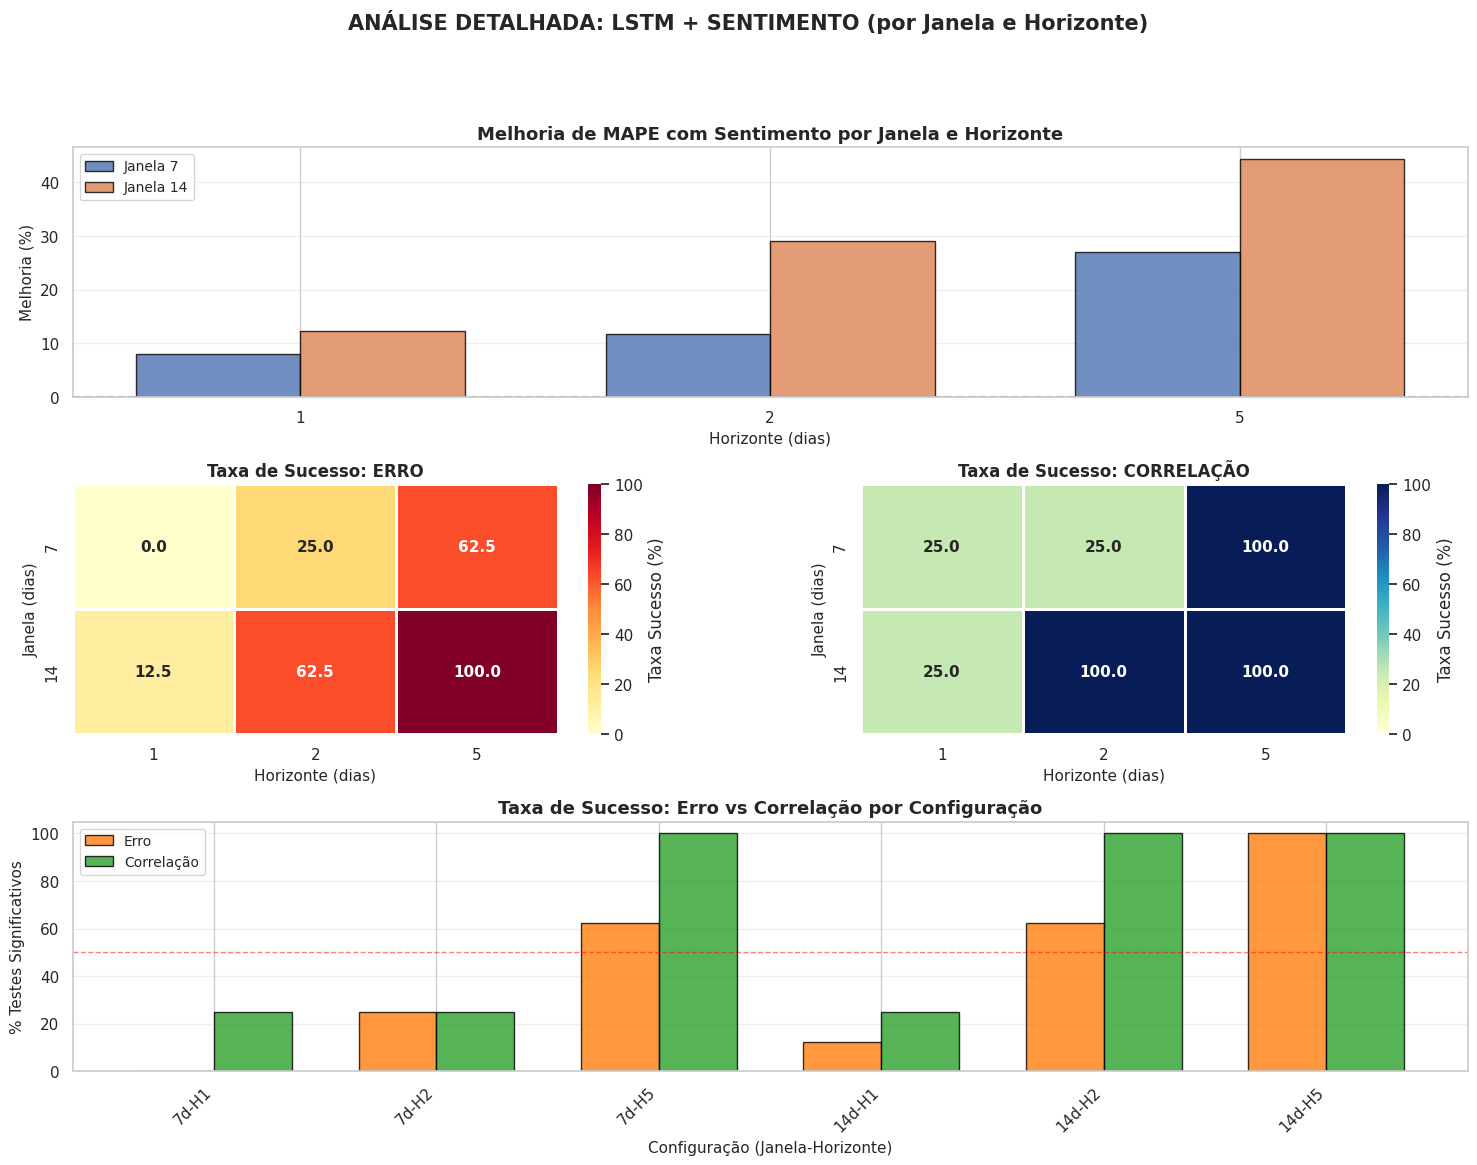


 CSV salvo: comparacao_mape_mae_agregado.csv
 CSV salvo: analise_detalhada_janela_horizonte.csv

 ANÁLISE CONCLUÍDA!


In [21]:
def analise_completa_hipoteses_detalhada(resultados_df, errors_df, summary_hipoteses_erro, summary_hipoteses_corr):
    """
    Adiciona análise detalhada por JANELA e HORIZONTE (não apenas por horizonte).
    Agora inclui MAE agregado e comparações Sem vs Com para MAE e MAPE.
    """

    # VERIFICA DADOS DISPONÍVEIS
    print("\n DADOS DISPONÍVEIS:")
    print(f"  - Resultados: {len(resultados_df)} linhas")
    print(f"  - Errors: {len(errors_df)} linhas")
    print(f"  - Testes de erro: {len(summary_hipoteses_erro)} linhas")
    print(f"  - Testes de correlação: {len(summary_hipoteses_corr)} linhas")

    janelas = sorted(resultados_df['Janela'].unique())
    horizontes = sorted(resultados_df['Horizon'].unique())
    print(f"  - Janelas: {janelas}")
    print(f"  - Horizontes: {horizontes}")


    # CALCULA MAPE E MAE AGREGADO
    print("\n" + "="*80)
    print(" MAPE e MAE AGREGADO (média entre ativos)")
    print("="*80)
    print("\nMAPE permite agregar ativos com preços diferentes:")
    print("  PETR4 ~R$40 vs BOVA11 ~R$130")

    mape_agregado = None
    comparacao_df = pd.DataFrame()

    if 'MAPE(%)' in resultados_df.columns and 'MAE' in resultados_df.columns:
        # Agrega por Janela, Horizon, Modo (já incluindo MAE)
        mape_agregado = resultados_df.groupby(['Janela', 'Horizon', 'Modo']).agg({
            'MAPE(%)': ['mean', 'std', 'min', 'max', 'count'],
            'MAE': ['mean', 'std'],
            'Correlação': ['mean', 'std']
        }).round(4)

        print("\n", mape_agregado)

        # Comparação direta: sem vs com sentimento (MAPE e MAE médio entre ativos)
        print("\n" + "-"*80)
        print(" COMPARAÇÃO: SEM vs COM SENTIMENTO (MAPE e MAE médios entre ativos)")
        print("-"*80)

        comparacao = []
        for janela in janelas:
            for horizon in horizontes:
                # MAPE sem / com
                sem_mape = resultados_df[
                    (resultados_df['Janela'] == janela) &
                    (resultados_df['Horizon'] == horizon) &
                    (resultados_df['Modo'] == 'sem_sent')
                ]['MAPE(%)'].mean()

                com_mape = resultados_df[
                    (resultados_df['Janela'] == janela) &
                    (resultados_df['Horizon'] == horizon) &
                    (resultados_df['Modo'] == 'com_sent_median')
                ]['MAPE(%)'].mean()

                # MAE sem / com
                sem_mae = resultados_df[
                    (resultados_df['Janela'] == janela) &
                    (resultados_df['Horizon'] == horizon) &
                    (resultados_df['Modo'] == 'sem_sent')
                ]['MAE'].mean()

                com_mae = resultados_df[
                    (resultados_df['Janela'] == janela) &
                    (resultados_df['Horizon'] == horizon) &
                    (resultados_df['Modo'] == 'com_sent_median')
                ]['MAE'].mean()

                # calcula melhorias (quando possível)
                if not np.isnan(sem_mape) and not np.isnan(com_mape):
                    dif_map = sem_mape - com_mape
                    mel_map_pct = (dif_map / sem_mape) * 100 if sem_mape != 0 else np.nan
                else:
                    dif_map = np.nan
                    mel_map_pct = np.nan

                if not np.isnan(sem_mae) and not np.isnan(com_mae):
                    dif_mae = sem_mae - com_mae
                    mel_mae_pct = (dif_mae / sem_mae) * 100 if sem_mae != 0 else np.nan
                else:
                    dif_mae = np.nan
                    mel_mae_pct = np.nan

                if not (np.isnan(sem_mape) and np.isnan(com_mape) and np.isnan(sem_mae) and np.isnan(com_mae)):
                    comparacao.append({
                        'Janela': janela,
                        'Horizon': horizon,
                        'MAPE_sem(%)': round(sem_mape, 4) if not np.isnan(sem_mape) else np.nan,
                        'MAPE_com(%)': round(com_mape, 4) if not np.isnan(com_mape) else np.nan,
                        'Dif_MAPE': round(dif_map, 4) if not np.isnan(dif_map) else np.nan,
                        'Melhoria_MAPE(%)': round(mel_map_pct, 2) if not np.isnan(mel_map_pct) else np.nan,
                        'MAE_sem': round(sem_mae, 6) if not np.isnan(sem_mae) else np.nan,
                        'MAE_com': round(com_mae, 6) if not np.isnan(com_mae) else np.nan,
                        'Dif_MAE': round(dif_mae, 6) if not np.isnan(dif_mae) else np.nan,
                        'Melhoria_MAE(%)': round(mel_mae_pct, 2) if not np.isnan(mel_mae_pct) else np.nan,
                        'Sentimento_Ajudou': '✓' if (not np.isnan(mel_map_pct) and mel_map_pct > 0) or (not np.isnan(mel_mae_pct) and mel_mae_pct > 0) else '✗'
                    })

        comparacao_df = pd.DataFrame(comparacao)
        print("\n", comparacao_df.to_string(index=False))

    # =========================================================================
    # ANÁLISE DETALHADA POR JANELA E HORIZONTE
    print("\n" + "="*80)
    print("ANÁLISE DETALHADA POR JANELA E HORIZONTE")
    print("="*80)

    analise_detalhada = []

    for janela in janelas:
        for h in horizontes:
            print(f"\n{'─'*80}")
            print(f" JANELA {janela} dias | HORIZONTE {h} dia(s)")
            print(f"{'─'*80}")

            # Recupera MAPE/MAE da tabela de comparação
            if not comparacao_df.empty:
                dados_jh = comparacao_df[
                    (comparacao_df['Janela'] == janela) &
                    (comparacao_df['Horizon'] == h)
                ]
                if len(dados_jh) > 0:
                    melhoria_mape = dados_jh['Melhoria_MAPE(%)'].iloc[0]
                    mape_sem = dados_jh['MAPE_sem(%)'].iloc[0]
                    mape_com = dados_jh['MAPE_com(%)'].iloc[0]
                    melhoria_mae = dados_jh['Melhoria_MAE(%)'].iloc[0]
                    mae_sem = dados_jh['MAE_sem'].iloc[0]
                    mae_com = dados_jh['MAE_com'].iloc[0]

                    print(f"\n MAPE:")
                    print(f"   Sem sentimento: {mape_sem:.4f}%")
                    print(f"   Com sentimento: {mape_com:.4f}%")
                    print(f"   Melhoria (MAPE): {melhoria_mape:+.2f}%")

                    print(f"\n MAE (média entre ativos):")
                    print(f"   Sem sentimento: {mae_sem:.6f}")
                    print(f"   Com sentimento: {mae_com:.6f}")
                    print(f"   Melhoria (MAE): {melhoria_mae:+.2f}%")
                else:
                    melhoria_mape = np.nan
                    mape_sem = np.nan
                    mape_com = np.nan
                    melhoria_mae = np.nan
                    mae_sem = np.nan
                    mae_com = np.nan
            else:
                melhoria_mape = np.nan
                mape_sem = np.nan
                mape_com = np.nan
                melhoria_mae = np.nan
                mae_sem = np.nan
                mae_com = np.nan

            # TESTES DE ERRO
            testes_erro_jh = summary_hipoteses_erro[
                (summary_hipoteses_erro['Janela'] == janela) &
                (summary_hipoteses_erro['Horizon'] == h)
            ]
            n_testes_erro = len(testes_erro_jh)
            sucessos_erro = testes_erro_jh['Modo1>Modo2'].sum()
            taxa_erro = (sucessos_erro / n_testes_erro * 100) if n_testes_erro > 0 else 0

            print(f"\n TESTES DE ERRO (p < 0.05):")
            print(f"   Sucessos: {sucessos_erro}/{n_testes_erro} ({taxa_erro:.1f}%)")

            # Por ticker - ERRO
            if n_testes_erro > 0:
                por_ticker_erro = testes_erro_jh.groupby('Ticker')['Modo1>Modo2'].agg(['sum', 'count'])
                print(f"\n Por ticker:")
                for ticker, row in por_ticker_erro.iterrows():
                    print(f"      {ticker}: {row['sum']}/{row['count']} ({row['sum']/row['count']*100:.0f}%)")

            # TESTES DE CORRELAÇÃO
            testes_corr_jh = summary_hipoteses_corr[
                (summary_hipoteses_corr['Janela'] == janela) &
                (summary_hipoteses_corr['Horizon'] == h)
            ]
            n_testes_corr = len(testes_corr_jh)
            sucessos_corr = testes_corr_jh['Modo1>Modo2'].sum()
            taxa_corr = (sucessos_corr / n_testes_corr * 100) if n_testes_corr > 0 else 0

            print(f"\n TESTES DE CORRELAÇÃO (p < 0.05):")
            print(f"   Sucessos: {sucessos_corr}/{n_testes_corr} ({taxa_corr:.1f}%)")

            # ADICIONADO: Por ticker - CORRELAÇÃO
            if n_testes_corr > 0:
                por_ticker_corr = testes_corr_jh.groupby('Ticker')['Modo1>Modo2'].agg(['sum', 'count'])
                print(f"\n Por ticker:")
                for ticker, row in por_ticker_corr.iterrows():
                    print(f"      {ticker}: {row['sum']}/{row['count']} ({row['sum']/row['count']*100:.0f}%)")

            # Total combinado
            total_sucessos = sucessos_erro + sucessos_corr
            total_testes = n_testes_erro + n_testes_corr
            taxa_total = (total_sucessos / total_testes * 100) if total_testes > 0 else 0

            print(f"\nTOTAL COMBINADO:")
            print(f"   {total_sucessos}/{total_testes} ({taxa_total:.1f}%)")

            analise_detalhada.append({
                'Janela': janela,
                'Horizon': h,
                'MAPE_sem(%)': mape_sem,
                'MAPE_com(%)': mape_com,
                'Melhoria_MAPE(%)': melhoria_mape,
                'MAE_sem': mae_sem,
                'MAE_com': mae_com,
                'Melhoria_MAE(%)': melhoria_mae,
                'Sucessos_Erro': sucessos_erro,
                'Total_Erro': n_testes_erro,
                'Taxa_Erro(%)': taxa_erro,
                'Sucessos_Corr': sucessos_corr,
                'Total_Corr': n_testes_corr,
                'Taxa_Corr(%)': taxa_corr,
                'Sucessos_Total': total_sucessos,
                'Total_Testes': total_testes,
                'Taxa_Total(%)': taxa_total
            })

    analise_df = pd.DataFrame(analise_detalhada)

    # RESUMO POR HORIZONTE (agregando janelas)
    print("\n" + "="*80)
    print(" RESUMO POR HORIZONTE (agregando janelas)")
    print("="*80)

    for h in horizontes:
        dados_h = analise_df[analise_df['Horizon'] == h]

        melhoria_media = dados_h['Melhoria_MAPE(%)'].mean()
        melhoria_mae_media = dados_h['Melhoria_MAE(%)'].mean()
        sucessos_erro_total = dados_h['Sucessos_Erro'].sum()
        total_erro_total = dados_h['Total_Erro'].sum()
        sucessos_corr_total = dados_h['Sucessos_Corr'].sum()
        total_corr_total = dados_h['Total_Corr'].sum()

        taxa_erro_h = (sucessos_erro_total / total_erro_total * 100) if total_erro_total > 0 else 0
        taxa_corr_h = (sucessos_corr_total / total_corr_total * 100) if total_corr_total > 0 else 0

        print(f"\nHorizonte {h}:")
        print(f"  MAPE: melhoria média {melhoria_media:+.2f}%")
        print(f"  MAE: melhoria média {melhoria_mae_media:+.2f}%")
        print(f"  Erro: {sucessos_erro_total}/{total_erro_total} ({taxa_erro_h:.1f}%)")
        print(f"  Correlação: {sucessos_corr_total}/{total_corr_total} ({taxa_corr_h:.1f}%)")

    # RESUMO GERAL
    print("\n" + "="*80)
    print("RESUMO GERAL")
    print("="*80)

    # Melhoria geral de MAPE
    if mape_agregado is not None and not comparacao_df.empty:
        melhoria_geral = comparacao_df['Melhoria_MAPE(%)'].mean()
        melhoria_mae_geral = comparacao_df['Melhoria_MAE(%)'].mean()
        print(f"\n MELHORIA GERAL DE MAPE: {melhoria_geral:+.2f}%")
        print(f"\n MELHORIA GERAL DE MAE: {melhoria_mae_geral:+.2f}%")
    else:
        melhoria_geral = np.nan
        melhoria_mae_geral = np.nan

    # Taxa de sucesso geral
    taxa_erro_geral = (summary_hipoteses_erro['Modo1>Modo2'].sum() / len(summary_hipoteses_erro) * 100) if len(summary_hipoteses_erro) > 0 else 0
    taxa_corr_geral = (summary_hipoteses_corr['Modo1>Modo2'].sum() / len(summary_hipoteses_corr) * 100) if len(summary_hipoteses_corr) > 0 else 0

    print(f"\n TAXA DE SUCESSO ESTATÍSTICO:")
    print(f"   - Erro: {taxa_erro_geral:.1f}%")
    print(f"   - Correlação: {taxa_corr_geral:.1f}%")


    print("\n" + "="*80)
    print("TABELA PARA LATEX")
    print("="*80)


    print("\nJanela & Hor. & MAPE Sem & MAPE Com & MAE Sem & MAE Com & Melh. (MAPE) & Melh. (MAE) & \\multicolumn{2}{c}{Testes Sig. ($p<0{,}05$)} \\\\")
    print("\\cmidrule(lr){9-10}")
    print(" & & & & & & & & Erros & Correlação \\\\")
    print("\\midrule")
    for _, row in analise_df.iterrows():
        mape_sem_val = row['MAPE_sem(%)'] if not pd.isna(row['MAPE_sem(%)']) else 0.0
        mape_com_val = row['MAPE_com(%)'] if not pd.isna(row['MAPE_com(%)']) else 0.0
        mae_sem_val = row['MAE_sem'] if not pd.isna(row['MAE_sem']) else 0.0
        mae_com_val = row['MAE_com'] if not pd.isna(row['MAE_com']) else 0.0
        mel_map_val = row['Melhoria_MAPE(%)'] if not pd.isna(row['Melhoria_MAPE(%)']) else 0.0
        mel_mae_val = row['Melhoria_MAE(%)'] if not pd.isna(row['Melhoria_MAE(%)']) else 0.0

        print(f"{int(row['Janela'])} & {int(row['Horizon'])} & "
              f"{mape_sem_val:.2f} & {mape_com_val:.2f} & "
              f"{mae_sem_val:.6f} & {mae_com_val:.6f} & "
              f"{mel_map_val:+.1f}\\% & {mel_mae_val:+.1f}\\% & "
              f"{int(row['Sucessos_Erro'])}/{int(row['Total_Erro'])} & "
              f"{int(row['Sucessos_Corr'])}/{int(row['Total_Corr'])} \\\\")


    print("\n" + "="*80)
    print("Gerando Gráficos...")
    print("="*80)

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

    # 1. MAPE por Janela e Horizonte
    ax1 = fig.add_subplot(gs[0, :])

    x = np.arange(len(horizontes))
    width = 0.35

    for i, janela in enumerate(janelas):
        dados_janela = analise_df[analise_df['Janela'] == janela]
        melhorias = dados_janela.sort_values('Horizon')['Melhoria_MAPE(%)'].values
        ax1.bar(x + i*width, melhorias, width, label=f'Janela {janela}',
                edgecolor='black', alpha=0.8)

    ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)
    ax1.set_title('Melhoria de MAPE com Sentimento por Janela e Horizonte',
                  fontsize=13, fontweight='bold')
    ax1.set_ylabel('Melhoria (%)', fontsize=11)
    ax1.set_xlabel('Horizonte (dias)', fontsize=11)
    ax1.set_xticks(x + width/2)
    ax1.set_xticklabels(horizontes)
    ax1.legend(fontsize=10)
    ax1.grid(axis='y', alpha=0.3)

    # 2. Heatmap: Taxa de Sucesso em ERRO (Janela x Horizonte)
    ax2 = fig.add_subplot(gs[1, 0])
    pivot_erro = analise_df.pivot(index='Janela', columns='Horizon', values='Taxa_Erro(%)')
    sns.heatmap(pivot_erro, annot=True, fmt='.1f', cmap='YlOrRd',
                cbar_kws={'label': 'Taxa Sucesso (%)'}, ax=ax2,
                linewidths=2, vmin=0, vmax=100,
                annot_kws={'size': 11, 'weight': 'bold'})
    ax2.set_title('Taxa de Sucesso: ERRO', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Janela (dias)', fontsize=11)
    ax2.set_xlabel('Horizonte (dias)', fontsize=11)

    # 3. Heatmap: Taxa de Sucesso em CORRELAÇÃO (Janela x Horizonte)
    ax3 = fig.add_subplot(gs[1, 1])
    pivot_corr = analise_df.pivot(index='Janela', columns='Horizon', values='Taxa_Corr(%)')
    sns.heatmap(pivot_corr, annot=True, fmt='.1f', cmap='YlGnBu',
                cbar_kws={'label': 'Taxa Sucesso (%)'}, ax=ax3,
                linewidths=2, vmin=0, vmax=100,
                annot_kws={'size': 11, 'weight': 'bold'})
    ax3.set_title('Taxa de Sucesso: CORRELAÇÃO', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Janela (dias)', fontsize=11)
    ax3.set_xlabel('Horizonte (dias)', fontsize=11)

    # 4. Comparação: Erro vs Correlação por configuração
    ax4 = fig.add_subplot(gs[2, :])

    analise_df['Config'] = analise_df['Janela'].astype(str) + 'd-H' + analise_df['Horizon'].astype(str)

    x_pos = np.arange(len(analise_df))
    width = 0.35

    ax4.bar(x_pos - width/2, analise_df['Taxa_Erro(%)'], width,
            label='Erro', color='#ff7f0e', edgecolor='black', alpha=0.8)
    ax4.bar(x_pos + width/2, analise_df['Taxa_Corr(%)'], width,
            label='Correlação', color='#2ca02c', edgecolor='black', alpha=0.8)

    ax4.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax4.set_title('Taxa de Sucesso: Erro vs Correlação por Configuração',
                  fontsize=13, fontweight='bold')
    ax4.set_ylabel('% Testes Significativos', fontsize=11)
    ax4.set_xlabel('Configuração (Janela-Horizonte)', fontsize=11)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(analise_df['Config'], rotation=45, ha='right')
    ax4.legend(fontsize=10)
    ax4.grid(axis='y', alpha=0.3)

    plt.suptitle('ANÁLISE DETALHADA: LSTM + SENTIMENTO (por Janela e Horizonte)',
                 fontsize=15, fontweight='bold', y=0.995)
    plt.show()

    # SALVA RESULTADOS
    if mape_agregado is not None and not comparacao_df.empty:
        comparacao_df.to_csv('comparacao_mape_mae_agregado.csv', index=False)
        print("\n CSV salvo: comparacao_mape_mae_agregado.csv")

    analise_df.to_csv('analise_detalhada_janela_horizonte.csv', index=False)
    print(" CSV salvo: analise_detalhada_janela_horizonte.csv")

    print("\n" + "="*80)
    print(" ANÁLISE CONCLUÍDA!")
    print("="*80)

    return {
        'comparacao_mape_mae': comparacao_df if not comparacao_df.empty else None,
        'analise_detalhada': analise_df,
        'melhoria_geral_mape': melhoria_geral,
        'melhoria_geral_mae': melhoria_mae_geral,
        'taxa_erro_geral': taxa_erro_geral,
        'taxa_corr_geral': taxa_corr_geral
    }

if __name__ == "__main__":
    resultados = analise_completa_hipoteses_detalhada(
        resultados_df=resultados_df,
        errors_df=errors_df,
        summary_hipoteses_erro=summary_hipoteses_erro,
        summary_hipoteses_corr=summary_hipoteses_corr
    )

# Keras

In [22]:
#!pip install keras-tuner

In [23]:
# import keras_tuner as kt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# def build_model(hp, window, n_features):
#     model = Sequential()

#     use_second = hp.Choice('use_second_lstm', [True, False])

#     # Primeira LSTM
#     model.add(LSTM(
#         units=hp.Int('units_lstm1', 32, 64, step=16),
#         return_sequences=use_second,
#         input_shape=(window, n_features)
#     ))
#     model.add(Dropout(hp.Float('dropout1', 0.1, 0.3, step=0.1)))

#     # Segunda LSTM opcional
#     if use_second:
#         model.add(LSTM(units=hp.Int('units_lstm2', 16, 64, step=16)))
#         model.add(Dropout(hp.Float('dropout2', 0.1, 0.3, step=0.1)))

#     model.add(Dense(hp.Int('dense_units', 16, 32, step=16)))
#     model.add(Dense(1))

#     lr = hp.Choice('learning_rate', [1e-3, 1e-4])
#     model.compile(optimizer=Adam(learning_rate=lr), loss='mae')
#     return model


# for ticker in TICKERS:
#     df = download_ticker_from_csv(ticker, START_DATE, END_DATE, CSV_FILE)
#     print(ticker, df.shape)
#     for window in WINDOWS:
#         data_values = df[FEATURES].values
#         scaler = MinMaxScaler()
#         scaled = scaler.fit_transform(data_values)
#         n_features = scaled.shape[1]


#         X, y = sequences_multi_horizon(scaled, window, horizon=1, close_col_idx=CLOSE_IDX)

#         split = int(len(X)*0.8)
#         X_train, y_train = X[:split], y[:split]
#         X_val, y_val = X[split:], y[split:]

#         tuner = kt.RandomSearch(
#             lambda hp: build_model(hp, window, n_features),
#             objective='val_loss',
#             max_trials=10,
#             executions_per_trial=1,
#             directory='tuner_results',
#             project_name=f'{ticker}_win{window}'
#         )

#         tuner.search(X_train, y_train,
#                      epochs=50,
#                      batch_size=8,
#                      validation_data=(X_val, y_val))

#         best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
#         print(f"{ticker} janela {window} -> melhores hiperparâmetros: {best_hps.values}")


In [24]:
# import os
# import keras_tuner as kt
# import pandas as pd

# base_dir = "tuner_results"
# resultados = []

# # Percorre todas as subpastas
# for project_name in os.listdir(base_dir):
#     project_path = os.path.join(base_dir, project_name)
#     if os.path.isdir(project_path):
#         try:

#             tuner = kt.RandomSearch(
#                 lambda hp: None,  # dummy, não importa aqui
#                 objective='val_loss',
#                 max_trials=10,
#                 executions_per_trial=1,
#                 directory=base_dir,
#                 project_name=project_name
#             )
#             # Pega o melhor trial
#             best_trial = tuner.oracle.get_best_trials(1)[0]
#             resultados.append({
#                 "Projeto": project_name,
#                 "Val_Loss": best_trial.score,
#                 **best_trial.hyperparameters.values
#             })
#         except Exception as e:
#             print(f"Erro ao carregar {project_name}: {e}")


# df = pd.DataFrame(resultados)

# # Ordena pelo menor erro
# df_sorted = df.sort_values("Val_Loss", ascending=True)

# print("\n Ranking geral dos melhores modelos:")
# print(df_sorted.to_string(index=False))

# # Frequência
# print("\n Frequencia dos hiperparametros vencedores:")
# for col in df.columns:
#     if col not in ["Projeto", "Val_Loss"]:
#         print(f"\n{col}:")
#         print(df[col].value_counts())
